In [3]:
%load_ext autoreload
%autoreload 2

import sys 

pths = ['/app/pml/']
for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)
        
from pml.utils import *
from pml.shapedataframe import ShapeDataFrame
import pml.camera2 as cam 
import pml.feature as af 
from pml.matrix_utils2 import MatrixUtils2 as mu

from ladybug_geometry.geometry2d.line import LineSegment2D

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# https://github.com/smidm/camera.py/blob/master/camera.py
    
def r(x): 
    return x / 180 * np.pi

def p2e(p):
    # Matrix of projective to euclidian
    return (p / p[-1, :])[0:-1, :].T

def e2p(e):
    # Matrix of euclidean to projective
    # Converts to column vectors
    return np.insert(e, 3, 1, 1).T

def lin(arr):
    return LineSegment2D.from_array(arr[:,:2])

def xform(emtx, geom):
    xgeom = []
    geom = e2p(geom)
    for i in range(geom.shape[1]):
        vec = geom[:, i]
        xvec = np.matmul(emtx, vec)
        xgeom.append(xvec)
    return p2e(np.array(xgeom).T)

def world_to_camera_basis():
    # Pose matrix flips y, z, inverts x
    return np.array([
        [-1,  0,  0,  0],
        [ 0,  0,  1,  0],
        [ 0,  1,  0,  0],
        [ 0,  0,  0,  1]
    ])

def extrinsic(heading, pitch, cposn, cht):
    origin = np.array([0, 0, 0])
    move = np.array([cposn[0], cposn[1], cht])
    
    # First rotation matrix
    axisZ = np.array([0, 0, 1])
    rmtx1 = mu.xform_rotation_matrix(origin, axisZ, heading)

    # Second rotation matrix
    axisX = np.array([1, 0, 0]) # Keep orthogonal basis for axis
    rmtx2 = mu.xform_rotation_matrix(origin, axisX, pitch)

    # Translation matrix
    tmtx1 = mu.xform_translation_matrix(move)
    
    # Pose matrix 
    pmtx1 = world_to_camera_basis()
    
    # Make xform
    emtx = np.matmul(rmtx1, rmtx2.T).T # Multiply in post-order
    #pp(np.round(emtx, 2))
    emtx = np.matmul(emtx, tmtx1.T).T
    #pp(np.round(emtx, 2))
    emtx = np.matmul(emtx, pmtx1)
    #pp(np.round(emtx, 2))
    xgeom = xform(emtx, geom)
    
    return xgeom

array([[ 0.71, -0.71,  0.  ,  0.  ],
       [ 0.71,  0.71,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])
array([[ 0.71,  0.71,  0.  ,  0.5 ],
       [-0.71,  0.71,  0.  ,  0.5 ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])
array([[-0.71,  0.  ,  0.71,  0.5 ],
       [ 0.71,  0.  ,  0.71,  0.5 ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])


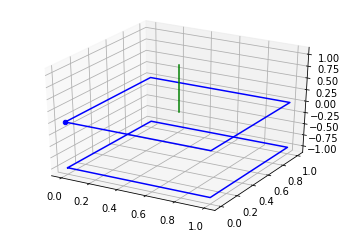

In [53]:
heading = r(-45)
pitch = r(0) # 45 down
cam_origin = [0.5, 0.5]
cam_ht = 0
geom = np.array([[0, 0, 0], [0, 1, 0]])

xgeom = extrinsic(heading, pitch, cam_origin, cam_ht)
#assert np.allclose(xgeom[1], [0, 0, -1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = xgeom[:, 0], xgeom[:, 1], xgeom[:, 2]
ax.plot3D([0,0,1,1,0], [0,1,1,0,0], [0,0,0,0,0], color='blue')
ax.plot3D([0,0,1,1,0], [0,1,1,0,0], -np.array([1,1,1,1,1]), color='blue')
ax.scatter3D([0],[0],[0], color='blue')
ax.plot3D(x, y, z, color='green')